In [13]:
#Import necessary analysis tools and data
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import CPTAC.Endometrial as en
import math

In [3]:
#Get acetylation data
acetyl = en.get_acetylproteomics()

In [4]:
#Show a list of clinical attributes that can be tested with acetylation data
list(en.get_clinical().columns)

['Proteomics_Participant_ID',
 'Case_excluded',
 'Proteomics_TMT_batch',
 'Proteomics_TMT_plex',
 'Proteomics_TMT_channel',
 'Proteomics_Parent_Sample_IDs',
 'Proteomics_Aliquot_ID',
 'Proteomics_Tumor_Normal',
 'Proteomics_OCT',
 'Country',
 'Histologic_Grade_FIGO',
 'Myometrial_invasion_Specify',
 'Histologic_type',
 'Treatment_naive',
 'Tumor_purity',
 'Path_Stage_Primary_Tumor-pT',
 'Path_Stage_Reg_Lymph_Nodes-pN',
 'Clin_Stage_Dist_Mets-cM',
 'Path_Stage_Dist_Mets-pM',
 'tumor_Stage-Pathological',
 'FIGO_stage',
 'LVSI',
 'BMI',
 'Age',
 'Diabetes',
 'Race',
 'Ethnicity',
 'Gender',
 'Tumor_Site',
 'Tumor_Site_Other',
 'Tumor_Focality',
 'Tumor_Size_cm',
 'Estrogen_Receptor',
 'Estrogen_Receptor_%',
 'Progesterone_Receptor',
 'Progesterone_Receptor_%',
 'MLH1',
 'MLH2',
 'MSH6',
 'PMS2',
 'p53',
 'Other_IHC_specify',
 'MLH1_Promoter_Hypermethylation',
 'Num_full_term_pregnancies',
 'EPIC_Bcells',
 'EPIC_CAFs',
 'EPIC_CD4_Tcells',
 'EPIC_CD8_Tcells',
 'EPIC_Endothelial',
 'EPIC_Mac

In [6]:
#For this use case, we will use 'Histologic_type'
clinical_attribute = "Histologic_type"
clinical = en.get_clinical()

#Merge attribute with acetylation dataframe
merged1 = en.compare_clinical(acetyl, clinical_attribute)
merged1.head()

idx,Histologic_type,A2M-K1168,A2M-K1176,A2M-K135,A2M-K145,A2M-K516,A2M-K664,A2M-K682,AACS-K391,AAGAB-K290,...,ZSCAN31-K215,ZSCAN32-K659,ZW10-K634,ZYX-K24,ZYX-K25,ZYX-K265,ZYX-K272,ZYX-K279,ZYX-K533,ZZZ3-K117
S001,Endometrioid,NaN,1.080,NaN,NaN,NaN,NaN,NaN,NaN,0.461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S002,Endometrioid,NaN,0.477,NaN,NaN,NaN,NaN,NaN,NaN,1.770,...,-0.104,-0.80300,NaN,-0.988,-0.343,-0.307,NaN,-0.0955,NaN,NaN
S003,Endometrioid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.815,...,NaN,NaN,NaN,-0.459,-1.170,NaN,NaN,-0.7050,0.089,NaN
S004,NaN,NaN,3.340,NaN,NaN,1.9155,0.566,NaN,NaN,NaN,...,NaN,-0.63600,NaN,0.223,-0.232,NaN,0.751,NaN,NaN,NaN
S005,Endometrioid,NaN,-0.608,NaN,NaN,-0.9190,NaN,NaN,NaN,NaN,...,-0.457,-0.00175,-0.33,NaN,-0.537,NaN,NaN,-0.3700,NaN,NaN


In [7]:
#Show possible variations of Histologic_type
clinical[[clinical_attribute]]

,Histologic_type
idx,
S001,Endometrioid
S002,Endometrioid
S003,Endometrioid
S005,Endometrioid
S006,Serous
S007,Endometrioid
S008,Endometrioid
S009,Serous
S010,Endometrioid


In [8]:
#Make dataframes with only endometrioid and only serous data in order to compare 
endom = merged1.loc[merged1[clinical_attribute] == "Endometrioid"]
serous = merged1.loc[merged1[clinical_attribute] == "Serous"]
merged1[[clinical_attribute]] = merged1[[clinical_attribute]].fillna(value="Normal")
#fillna
#downsize to change correction for p-value (missing data)

In [15]:
#Here we will calculate the number of significant sites, or in other words we will exclude any sites that don't...
# ...have enough data to show a statistically significant p-value
numSigSites = 0
for num in range(1,len(merged1.columns)):
    site = merged1.columns[num]
    oneSite = merged1[[clinical_attribute, site]]
    needNum = 0 #Number that we need to reach of values so that we can call the values significant
    for index, row in oneSite.iterrows():
        if row[clinical_attribute] == 'Serous' and not math.isnan(row[site]):
            needNum += 1
            if needNum == 5: #If we have more than 5 values that aren't NaN, we will use this column as significant.
                numSigSites += 1
                break
print(numSigSites)

3936


In [17]:
threshold = .05 / numSigSites #Here we use the number we calculated in the previous cell to calculate the p-value
print("Threshold:", threshold)
significantTests = []
significantSites = []
sigSiteCount = 0
for num in range(1,len(merged1.columns)):
    site = merged1.columns[num]
    oneSite = merged1[[clinical_attribute, site]]
    ttestRes = scipy.stats.ttest_ind(endom[site], serous[site])
    if (ttestRes[1] <= threshold): #Check if there is a significant enough difference between data points
        sigSiteCount += 1
        significantTests.append(ttestRes)
        significantSites.append(site)
print(sigSiteCount)

Threshold: 1.2703252032520325e-05
8


In [18]:
print(significantSites)

['FOXA2-K280', 'FUS-K332', 'JADE3-K32', 'MCRS1-K136', 'MEAF6-K69', 'NCL-K398', 'SUPT16H-K674', 'TBL1XR1-K102']


Ttest_indResult(statistic=5.991702127182772, pvalue=3.89570439448459e-08)


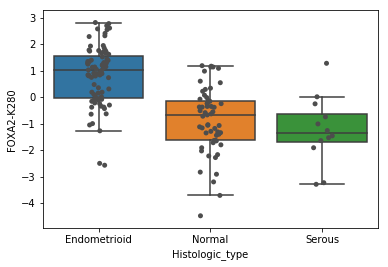

In [19]:
graphingSite = 'FOXA2-K280'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data = merged1, showfliers = False)
sns.stripplot(x=clinical_attribute, y=graphingSite, data = merged1, color = '.3')

Ttest_indResult(statistic=-4.69713782197463, pvalue=9.090116393624886e-06)


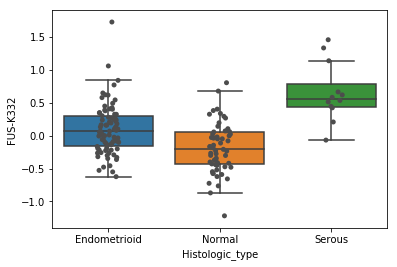

In [21]:
graphingSite = 'FUS-K332'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data = merged1, showfliers = False)
sns.stripplot(x=clinical_attribute, y=graphingSite, data = merged1, color = '.3')

Ttest_indResult(statistic=-5.264353282778082, pvalue=9.009261990390327e-07)


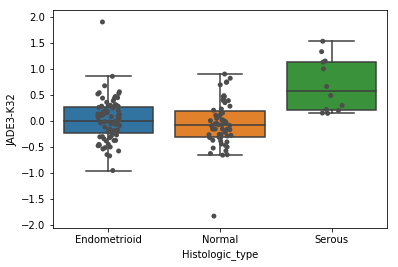

In [22]:
graphingSite = 'JADE3-K32'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data = merged1, showfliers = False)
sns.stripplot(x=clinical_attribute, y=graphingSite, data = merged1, color = '.3')

Ttest_indResult(statistic=-4.905999919645725, pvalue=3.94259188205917e-06)


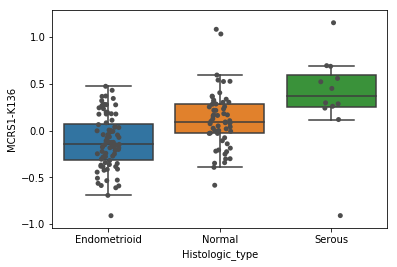

In [23]:
graphingSite = 'MCRS1-K136'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data = merged1, showfliers = False)
sns.stripplot(x=clinical_attribute, y=graphingSite, data = merged1, color = '.3')

Ttest_indResult(statistic=-5.3886215048866974, pvalue=5.336611006090782e-07)


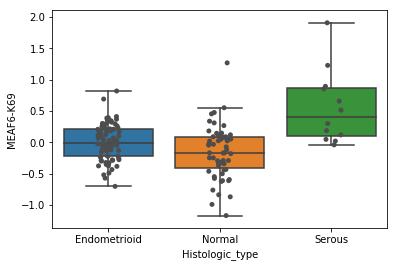

In [24]:
graphingSite = 'MEAF6-K69'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data = merged1, showfliers = False)
sns.stripplot(x=clinical_attribute, y=graphingSite, data = merged1, color = '.3')

Ttest_indResult(statistic=-5.517844309062241, pvalue=3.0773084577689524e-07)


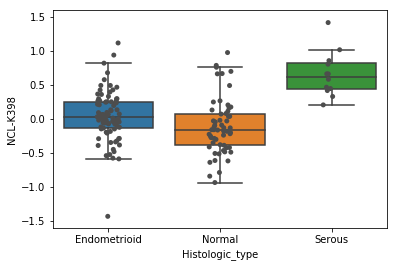

In [25]:
graphingSite = 'NCL-K398'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data = merged1, showfliers = False)
sns.stripplot(x=clinical_attribute, y=graphingSite, data = merged1, color = '.3')

Ttest_indResult(statistic=-4.690071539871116, pvalue=9.34749100983442e-06)


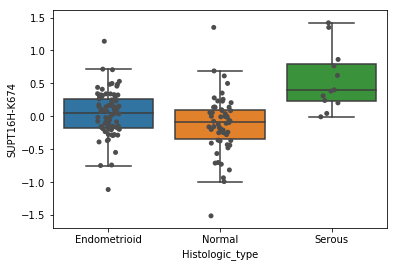

In [26]:
graphingSite = 'SUPT16H-K674'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data = merged1, showfliers = False)
sns.stripplot(x=clinical_attribute, y=graphingSite, data = merged1, color = '.3')

Ttest_indResult(statistic=-6.058405376720225, pvalue=2.8961545616585784e-08)


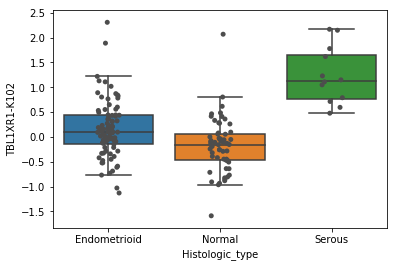

In [27]:
graphingSite = 'TBL1XR1-K102'
print(scipy.stats.ttest_ind(endom[graphingSite], serous[graphingSite]))
sns.boxplot(x=clinical_attribute, y=graphingSite, data = merged1, showfliers = False)
sns.stripplot(x=clinical_attribute, y=graphingSite, data = merged1, color = '.3')